# Trabajo Final de Master

Este notebook contiene los códigos y desarrollos para estudiar diferentes modelos de movilidad y aplocarlos para el caso puntual de la ciudad de Bogotá

### Primera Parte. Tratamiento de datos de la encuesta de movilidad del 2019

En esta primera parte se hace un primer llamado a la encuesta de movilidad del año 2019 de Bogotá, en donde se estudiará la calidad de la fuente de datos y se crearan matrices origen destino para todos los medios de transporte, y así verificar si los datos se ajustan a un modelo gravitacional.

In [64]:
# Calling the libreries 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import geopy.distance
from shapely.geometry import LineString
from pyproj import Geod
from scipy.optimize import curve_fit

# Declaring the paths of the trips data
trips_path = r'./Encuesta de Movilidad 2019/EODH/Archivos_CSV/ViajesEODH2019.csv'
# Path of the population data
houses_path = r'./Encuesta de Movilidad 2019/EODH/Archivos_CSV/HogaresEODH2019.csv'
# Path of the ZATs shapefiles
shape_path = r'./Encuesta de Movilidad 2019/Zonificacion_(shapefiles)/ZONAS/ZONAS/ZAT.shp'
# Path of the streets shapefile
streets_path = r'./Encuesta de Movilidad 2019/Zonificacion_(shapefiles)/Malla_Vial_Integral_Bogota_D_C/Malla_Vial_Integral_Bogota_D_C.shp'
# Path of the "Localidades" shapefile
loc_path = r'./Encuesta de Movilidad 2019/Zonificacion_(shapefiles)/loca/Loca.shp'
# Converting the CSV in a pandas dataframe
trips_df = pd.read_csv(trips_path, sep = ';')
# Converting the population data to dataframe
houses_df = pd.read_csv(houses_path, sep= ';', low_memory=False)
# Calling the ZAT's shapefile
zats_map = gpd.read_file(shape_path)
# Calling the streets shapefile
#streets_map = gpd.read_file(streets_path)
# Calling the "Localidades" shapefile
loc_map = gpd.read_file(loc_path)

# Function which plots the map of Bogotá 
def map(zat):
    fig, ax = plt.subplots(1, 1, figsize=(25, 25))
    loc_map.boundary.plot(ax=ax, color='black')
    zats_map[zats_map['ZAT']==zat].plot(color='g', ax=ax)
    plt.plot()

# Computing the centroid of each zat
zats_map['center'] = zats_map.to_crs('+proj=cea').centroid.to_crs(zats_map.crs)

Ok como una primera aproximación no se van a filtrar los datos por tiempos de viaje, ni velocidades, por lo cual, en esta primera parte se tendrán en cuenta todos los datos.
La otra cuestión es que, como me sucedio en mi TFG, el muestreo sobre los de mas municipios está mal hecho, con los datos utilizados Bojaca tendría una población mayor a Faca y eso obviamente no es congruente con la vida real y el modelo estaría incorrecto, por lo cual, de nuevo, se van a utilizar solo datos en donde los vijes sean en Bogotá o Soacha.

In [65]:
# Filtering the data in order to take only the trips in Bogotá and Soacha
trips_df = trips_df[(trips_df['mun_origen'] == 11001) | (trips_df['mun_origen'] == 25754)]
trips_df = trips_df[(trips_df['mun_destino'] == 11001) | (trips_df['mun_destino'] == 25754)]
houses_df = houses_df[(houses_df['municipio'] == 11001) | (houses_df['municipio'] == 25754)]

In [66]:
# Computing the population per zat
population = houses_df[['zat_hogar', 'p7_total_personas']]
population = population.groupby('zat_hogar').agg('sum').sort_values(by='p7_total_personas', ascending=False)

Dado que el modelo gravitacional escala como $r^{-1}$, no podemos tener en cuenta viajes dentro de una misma ZAT, por lo cual estos serán filtrados.

In [67]:
# Computing the number of trips between diferent zats 
num_trips_df = trips_df[['zat_origen', 'zat_destino']]
#num_trips_df['trips'] = np.ones(len(num_trips_df)) 
num_trips_df.loc[0:, ['trips']] = 1
num_trips_df = (num_trips_df.groupby(['zat_origen', 'zat_destino'], as_index=False)['trips']
                            .agg('sum')
                            .sort_values(by='trips', ascending=False))
num_trips_df = num_trips_df[num_trips_df['zat_destino'] != num_trips_df['zat_origen']]

Dado que el modelo gravitacional es simetrico, debemos sumar los viajes de "ida y de regreso" entre dos ZATs, por lo cual, vamos a convertir el numero de viajes en una matriz y la sumamos con su transpuesta para simetrizar esta matriz, y luego la convertimos en columna de nuevo. 

In [68]:
# Symmetrizing the number of trips between each zat
table = pd.pivot_table(num_trips_df, values='trips', index='zat_origen', columns='zat_destino').fillna(0)
table = table + table.T

sim_num_trips = (table.stack()
                      .to_frame()
                      .reset_index()
                      .rename(columns={'level_0': 'zat_origen', 'level_1': 'zat_destino', 0: 'trips'})
                      .sort_values(by='trips', ascending=False))
sim_num_trips = sim_num_trips[sim_num_trips['trips']>0]
#sim_num_trips

In [69]:
# Adding the centroid coordinates to the df

num_dis_trips = (num_trips_df.merge(zats_map[['ZAT', 'center']], left_on='zat_origen', right_on='ZAT')
                             .rename(columns={'center': 'Origin_center'})
                             .drop(columns='ZAT'))
num_dis_trips = (num_dis_trips.merge(zats_map[['ZAT', 'center']], left_on='zat_destino', right_on='ZAT')
                             .rename(columns={'center': 'Destination_center'})
                             .drop(columns='ZAT'))
#num_dis_trips.sort_values(by='trips', ascending=False)

In [70]:
# Adding the centroid coordinates to the symmetrical df

num_dis_sim = (sim_num_trips.merge(zats_map[['ZAT', 'center']], left_on='zat_origen', right_on='ZAT')
                             .rename(columns={'center': 'Origin_center'})
                             .drop(columns='ZAT'))
num_dis_sim = (num_dis_sim.merge(zats_map[['ZAT', 'center']], left_on='zat_destino', right_on='ZAT')
                             .rename(columns={'center': 'Destination_center'})
                             .drop(columns='ZAT'))
#num_dis_sim.sort_values(by='trips', ascending=False)

In [71]:
line = LineString([num_dis_sim['Origin_center'].iloc[0], num_dis_sim['Destination_center'].iloc[0]])
geod = Geod(ellps = 'WGS84')
geod.geometry_length(line)/1000

0.7829163118920128

In [72]:
# Calculating the distances in Km
distance = []
geod = Geod(ellps = 'WGS84')
for i in range(len(num_dis_sim)):
    line = LineString([num_dis_sim['Origin_center'].iloc[i], num_dis_sim['Destination_center'].iloc[i]])
    dist = geod.geometry_length(line)/1000
    distance.append(dist)

num_dis_sim['distance'] = distance
num_dis_sim

,zat_origen,zat_destino,trips,Origin_center,Destination_center,distance
0,530.0,551.0,139.0,POINT (-74.17593 4.63213),POINT (-74.18166 4.62800),0.782916
1,782.0,551.0,2.0,POINT (-74.22095 4.58524),POINT (-74.18166 4.62800),6.431022
2,744.0,551.0,1.0,POINT (-74.10989 4.50800),POINT (-74.18166 4.62800),15.476600
3,743.0,551.0,4.0,POINT (-74.10280 4.51207),POINT (-74.18166 4.62800),15.521650
4,553.0,551.0,28.0,POINT (-74.18640 4.64169),POINT (-74.18166 4.62800),1.602353
...,...,...,...,...,...,...
71901,51.0,132.0,2.0,POINT (-74.04325 4.73873),POINT (-74.08181 4.70918),5.384070
71902,291.0,132.0,2.0,POINT (-74.07960 4.64932),POINT (-74.08181 4.70918),6.623682
71903,61.0,1054.0,2.0,POINT (-74.03527 4.73575),POINT (-74.10737 4.77009),8.854207
71904,741.0,739.0,4.0,POINT (-74.11884 4.50848),POINT (-74.12425 4.50978),0.617501


In [73]:
# Adding the number of person in th esurvey per zat 
num_dis_sim = (num_dis_sim.merge(population, left_on='zat_origen', right_on='zat_hogar')
                          .rename(columns={'p7_total_personas': 'Origin Population'}))
num_dis_sim = (num_dis_sim.merge(population, left_on='zat_destino', right_on='zat_hogar')
                          .rename(columns={'p7_total_personas': 'Dest Population'})
                          .sort_values(by='trips', ascending=False)
                          .drop(columns=['Origin_center', 'Destination_center']))
num_dis_sim = num_dis_sim[['zat_origen', 'zat_destino', 'Origin Population', 'Dest Population', 'distance', 'trips']]
num_dis_sim.head(20)

,zat_origen,zat_destino,Origin Population,Dest Population,distance,trips
0,530.0,551.0,518,145,0.782916,139.0
31215,551.0,530.0,145,518,0.782916,139.0
21597,775.0,776.0,184,311,0.666617,112.0
26239,776.0,775.0,311,184,0.666617,112.0
36250,714.0,1050.0,64,229,2.542549,105.0
49804,1050.0,714.0,229,64,2.542549,105.0
26359,782.0,783.0,187,230,0.860003,100.0
34597,783.0,782.0,230,187,0.860003,100.0
21598,777.0,776.0,274,311,0.899247,96.0
26325,776.0,777.0,311,274,0.899247,96.0


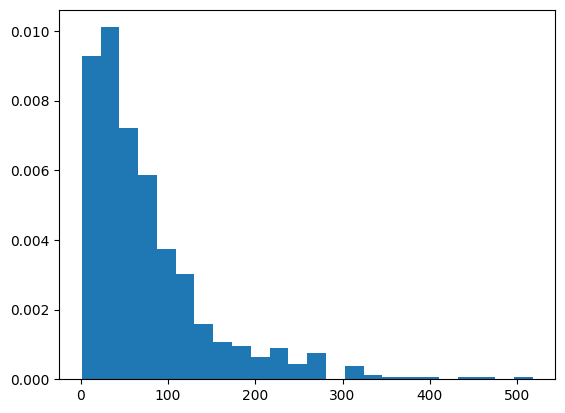

In [74]:
# Distribution of the population 
pltn_y, pltn_x = np.histogram(population['p7_total_personas'], bins=int(len(population)/30), density=True)
plt.stairs(pltn_y, pltn_x, fill=True)
plt.show()

Con los datos organozados debidamente, se va a definir la función del modelo y se ajustarán los datos utilizando el metodo curve_fit de scipy para obtener un primer estimado de los parametros del modelo, posteriormente se usarán tecnicas mas rigurosas como el most likelyhood estimator y, usando los resultados del curve_fit aplicar inferencia bayesiana.

In [ ]:
# Declaring the gravity function
def gravity(Data, K, a):
    P_1, P_2, d = Data
    T = K*(P_*P_2)/(d**a)
    return T